In [2]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import matplotlib as mpl
import scipy.stats as st
from scipy.stats import (vonmises_line, norm, t, cauchy, lognorm, fisk, skewnorm, exponweib, genlogistic, logistic, laplace)

from scipy import stats

import random

import glob
import os
from tqdm import tqdm

### Define colors an colormaps

In [3]:
# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

### Read data, add date, Calibrate flux for MDI using 0.8 factor, and apply 3x10^21 Mx cuttoff

In [4]:
# Flux Cutoff in Maxwells
fCutoff = 3e21

KPVT = pd.read_csv('data/output/BARD_1976-1993_KPVT_tilts.csv')
KPVT = KPVT.loc[KPVT['BMRFlux']>=fCutoff,:]
KPVT['Date'] = pd.to_datetime(dict(year=KPVT.Year, month=KPVT.Month, day=KPVT.Day, hour=KPVT.Hour, minute=KPVT.Minute))
KPVT['Instrument'] = 'KPVT'

SPMG = pd.read_csv('data/output/BARD_1992-1999_SPMG_tilts.csv')
SPMG = SPMG.loc[SPMG['BMRFlux']>=fCutoff,:]
SPMG['Date'] = pd.to_datetime(dict(year=SPMG.Year, month=SPMG.Month, day=SPMG.Day, hour=SPMG.Hour, minute=SPMG.Minute))
SPMG['Instrument'] = 'SPMG'
SPMG['BMRLabel'] = SPMG['BMRLabel'] + np.max(KPVT['BMRLabel'])

MDIcalibration = 0.8
MDI = pd.read_csv('data/output/BARD_1996-2010_MDI_tilts.csv')
MDI.loc[:, ['PFlux', 'NFlux', 'BMRFlux']] *= MDIcalibration
MDI = MDI.loc[MDI['BMRFlux']>=fCutoff,:]
MDI['Date'] = pd.to_datetime(dict(year=MDI.Year, month=MDI.Month, day=MDI.Day, hour=MDI.Hour, minute=MDI.Minute))
MDI['Instrument'] = 'MDI'
MDI['BMRLabel'] = MDI['BMRLabel'] + np.max(SPMG['BMRLabel'])

HMI = pd.read_csv('data/output/BARD_2010-2016_HMI_tilts.csv')
HMI = HMI.loc[HMI['BMRFlux']>=fCutoff,:]
HMI['Date'] = pd.to_datetime(dict(year=HMI.Year, month=HMI.Month, day=HMI.Day, hour=HMI.Hour, minute=HMI.Minute))
HMI['Instrument'] = 'HMI'
HMI['BMRLabel'] = HMI['BMRLabel'] + np.max(MDI['BMRLabel'])


In [5]:
HMI

ReferenceDay  Year  Month  Day  Hour  Minute  Second  BMRLabel  \
1              486  2010      5    2    21      46    22.4     13425   
4              488  2010      5    4    21      46    22.6     13428   
5              490  2010      5    6    21      46    22.9     13429   
6              507  2010      5   23    21      46    24.7     13430   
7              512  2010      5   28    21      46    25.1     13431   
...            ...   ...    ...  ...   ...     ...     ...       ...   
1448          2719  2016      6   12    21      46    46.7     16059   
1451          2724  2016      6   17    21      46    46.9     16063   
1453          2725  2016      6   18    21      46    47.0     16066   
1454          2727  2016      6   20    21      46    47.0     16068   
1455          2736  2016      6   29    21      46    47.2     16073   

             PFlux         PArea  ...  HH_24n  AH_24n  HH_24s  AH_24s  \
1     5.720000e+21  2.400000e+19  ...    True   False   False   False   
4     3.050000e+21  1.570000e+19  ...   False   False    True   False   
5     4.240000e+21  1.410000e+19  ...    True   False   False   False   
6     3.420000e+21  7.870000e+18  ...   False   False    True   False   
7     2.150000e+21  8.790000e+18  ...    True   False   False   False   
...            ...           ...  ...     ...     ...     ...     ...   
1448  4.150000e+21  2.040000e+19  ...    True   False   False   False   
1451  3.950000e+21  1.390000e+19  ...   False   False    True   False   
1453  2.080000e+21  1.060000e+19  ...    True   False   False   False   
1454  1.150000e+22  2.030000e+19  ...   False   False    True   False   
1455  2.120000e+21  9.190000e+18  ...    True   False   False   False   

      Cycle24n  Cycle24s  Hale  AntiHale                Date  Instrument  
1         True     False  True     False 2010-05-02 21:46:00         HMI  
4        False      True  True     False 2010-05-04 21:46:00         HMI  
5         True     False  True     False 2010-05-06 21:46:00         HMI  
6        False      True  True     False 2010-05-23 21:46:00         HMI  
7         True     False  True     False 2010-05-28 21:46:00         HMI  
...        ...       ...   ...       ...                 ...         ...  
1448      True     False  True     False 2016-06-12 21:46:00         HMI  
1451     False      True  True     False 2016-06-17 21:46:00         HMI  
1453      True     False  True     False 2016-06-18 21:46:00         HMI  
1454     False      True  True     False 2016-06-20 21:46:00         HMI  
1455      True     False  True     False 2016-06-29 21:46:00         HMI  

[1158 rows x 40 columns]

### Remove overlaps between missions

In [6]:
KPVT = KPVT.loc[KPVT['Date']<np.min(SPMG['Date']),:]
SPMG = SPMG.loc[SPMG['Date']<np.min(MDI['Date']),:]
MDI = MDI.loc[MDI['Date']<np.min(HMI['Date']),:]

### Concatenate all instruments

In [7]:
allMag = pd.concat([KPVT, SPMG, MDI, HMI], ignore_index=True).drop(labels=['ReferenceDay', 'Flux_cut'], axis=1).replace(np.nan, False)
allMag.to_csv('data/output/BARD_1976-2016_Merge_tilts.csv', index=False)

allMag['pltSize'] = (np.sqrt(allMag['BMRFlux']/1e21))
allMag

Year  Month  Day  Hour  Minute  Second  BMRLabel         PFlux  \
0     1976      1   13    17      26    59.0         1  6.690000e+21   
1     1976      2   15    18      19     8.0         3  2.370000e+21   
2     1976      2   20    18      43    18.0         4  2.490000e+21   
3     1976      3   13    21      24    36.0         8  3.080000e+21   
4     1976      8   12    21      14     0.0        13  1.790000e+21   
...    ...    ...  ...   ...     ...     ...       ...           ...   
7565  2016      6   12    21      46    46.7     16059  4.150000e+21   
7566  2016      6   17    21      46    46.9     16063  3.950000e+21   
7567  2016      6   18    21      46    47.0     16066  2.080000e+21   
7568  2016      6   20    21      46    47.0     16068  1.150000e+22   
7569  2016      6   29    21      46    47.2     16073  2.120000e+21   

             PArea  PLatitude  ...  AH_23s  Cycle23n  Cycle23s  HH_24n  \
0     1.590000e+19    -9.9094  ...   False     False     False   False   
1     1.170000e+19   -11.1080  ...   False     False     False   False   
2     1.440000e+19    -2.6919  ...   False     False     False   False   
3     1.270000e+19   -33.7100  ...   False     False     False   False   
4     9.400000e+18    23.7860  ...   False     False     False   False   
...            ...        ...  ...     ...       ...       ...     ...   
7565  2.040000e+19     4.1443  ...   False     False     False    True   
7566  1.390000e+19    -8.5136  ...   False     False     False   False   
7567  1.060000e+19     6.2451  ...   False     False     False    True   
7568  2.030000e+19    -6.1588  ...   False     False     False   False   
7569  9.190000e+18    16.0060  ...   False     False     False    True   

      AH_24n  HH_24s  AH_24s  Cycle24n  Cycle24s   pltSize  
0      False   False   False     False     False  4.614109  
1      False   False   False     False     False  1.939072  
2      False   False   False     False     False  2.209072  
3      False   False   False     False     False  2.424871  
4      False   False   False     False     False  1.769181  
...      ...     ...     ...       ...       ...       ...  
7565   False   False   False      True     False  2.716616  
7566   False    True   False     False      True  2.505993  
7567   False   False   False      True     False  2.017424  
7568   False    True   False     False      True  3.506565  
7569   False   False   False      True     False  2.291288  

[7570 rows x 57 columns]

In [8]:
for k in allMag.BMRLabel:
    df_k = pd.DataFrame((allMag.BMRLabel==k))*1
    
allMag[allMag.BMRLabel==247].index[1]
#allMag.drop(135,axis=0)

136

In [9]:
for k in allMag.BMRLabel:
    df_k = (allMag.BMRLabel==k)*1
    suma = df_k.sum()#[0]
    if suma > 1:
        index_1 = allMag[allMag.BMRLabel==k].index[1]
        allMag = allMag.drop(index_1, axis=0)

In [10]:
df = pd.DataFrame(allMag.BMRLabel)
counter = 0
for k in allMag.BMRLabel:
    df_k = (allMag.BMRLabel==k)*1
    suma = df_k.sum()#[0]
    if suma > 1:
        counter +=1
        print('Problema en BMRLabel ', k)

In [11]:
allMag = allMag.reset_index()

### Plot data

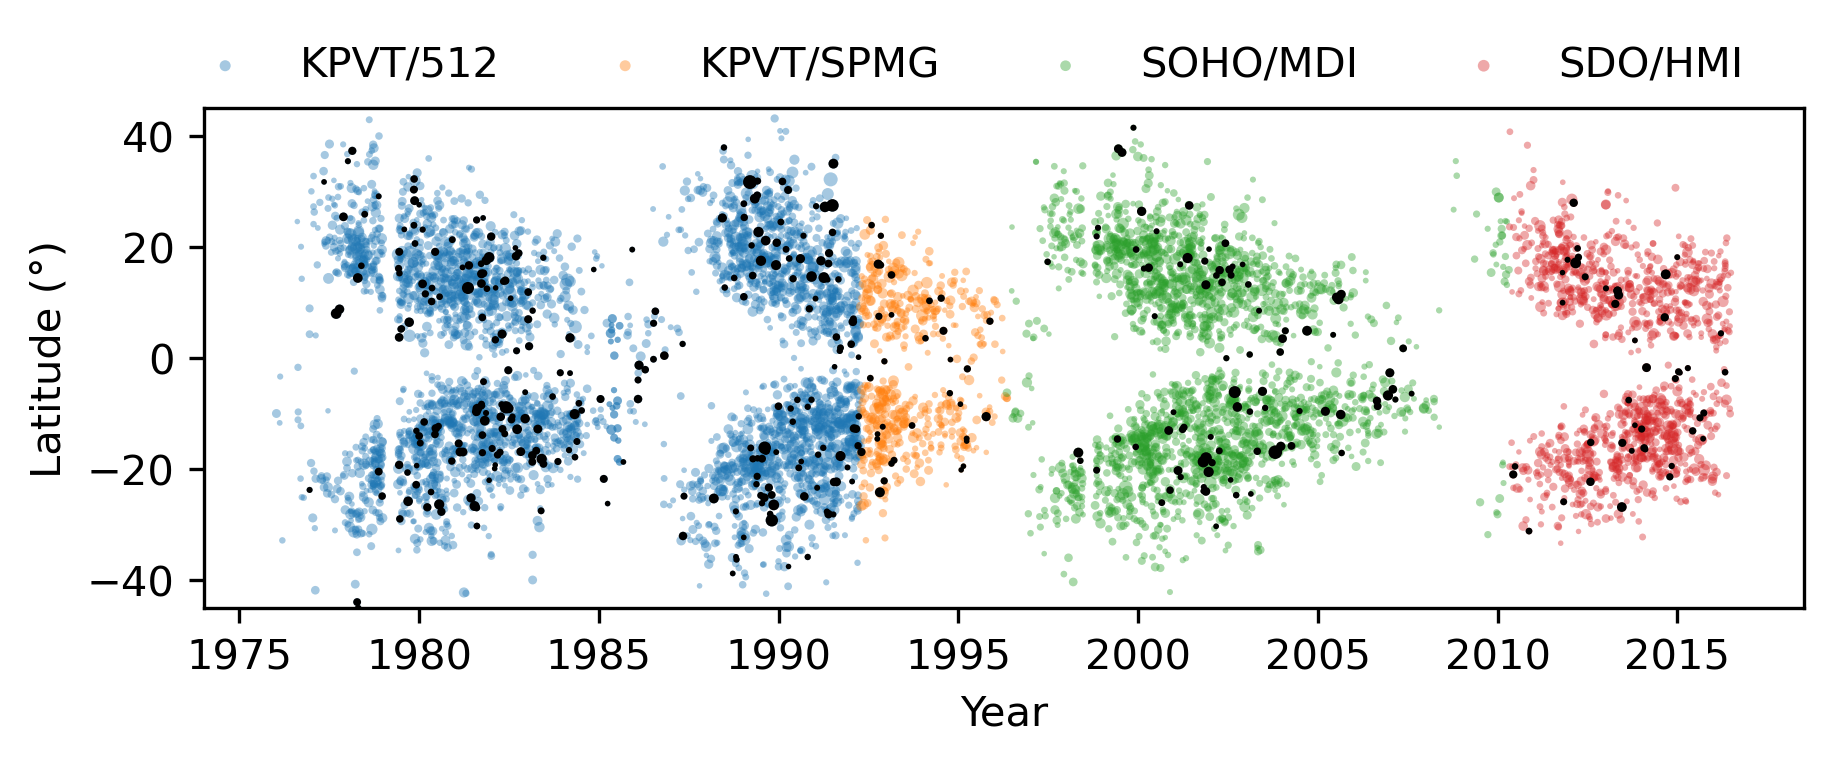

In [12]:
# Size definitions
dpi = 300
pxx = 1600  # Horizontal size of each panel
pxy = 500  # Vertical size of each panel

nph = 5     # Number of horizontal panels
npv = 6     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

ax1 = fig.add_axes([ppadh, ppadv, ppxx, ppxy])

size = (np.sqrt(KPVT['BMRFlux']/1e21))
ax1.scatter(KPVT['Date'], KPVT['BMRLatitude'], s=size, alpha=0.4, ec='None', label='KPVT/512')


size = (np.sqrt(SPMG['BMRFlux']/1e21))
ax1.scatter(SPMG['Date'], SPMG['BMRLatitude'], s=size, alpha=0.4, ec='None', label='KPVT/SPMG')


size = (np.sqrt(MDI['BMRFlux']/1e21))
ax1.scatter(MDI['Date'], MDI['BMRLatitude'], s=size, alpha=0.4, ec='None', label='SOHO/MDI')


size = (np.sqrt(HMI['BMRFlux']/1e21))
ax1.scatter(HMI['Date'], HMI['BMRLatitude'], s=size, alpha=0.4, ec='None', label='SDO/HMI')


size = (np.sqrt(allMag['BMRFlux']/1e21))
mask = allMag['AntiHale']
ax1.scatter(allMag.loc[mask,'Date'], allMag.loc[mask,'BMRLatitude'], s=size[mask], alpha=1,fc='k', ec='None')


ax1.set_ylim([-45, 45])
ax1.set_ylabel('Latitude (°)')
ax1.set_xlabel('Year')
ax1.legend(frameon=False, ncol=4, loc='upper center', bbox_to_anchor=(0.475, 1.2))



# Tilt Distributions for different cycles

/tmp/ipykernel_16405/1269498155.py:43: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(allMag.loc[mask,'Date'], allMag.loc[mask,'BMRLatitude'], s=size[mask], alpha=0.4, ec='None', label=f'Cycle{str(cyc)}', c=Clr[cyc-19])
/tmp/ipykernel_16405/1269498155.py:43: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(allMag.loc[mask,'Date'], allMag.loc[mask,'BMRLatitude'], s=size[mask], alpha=0.4, ec='None', label=f

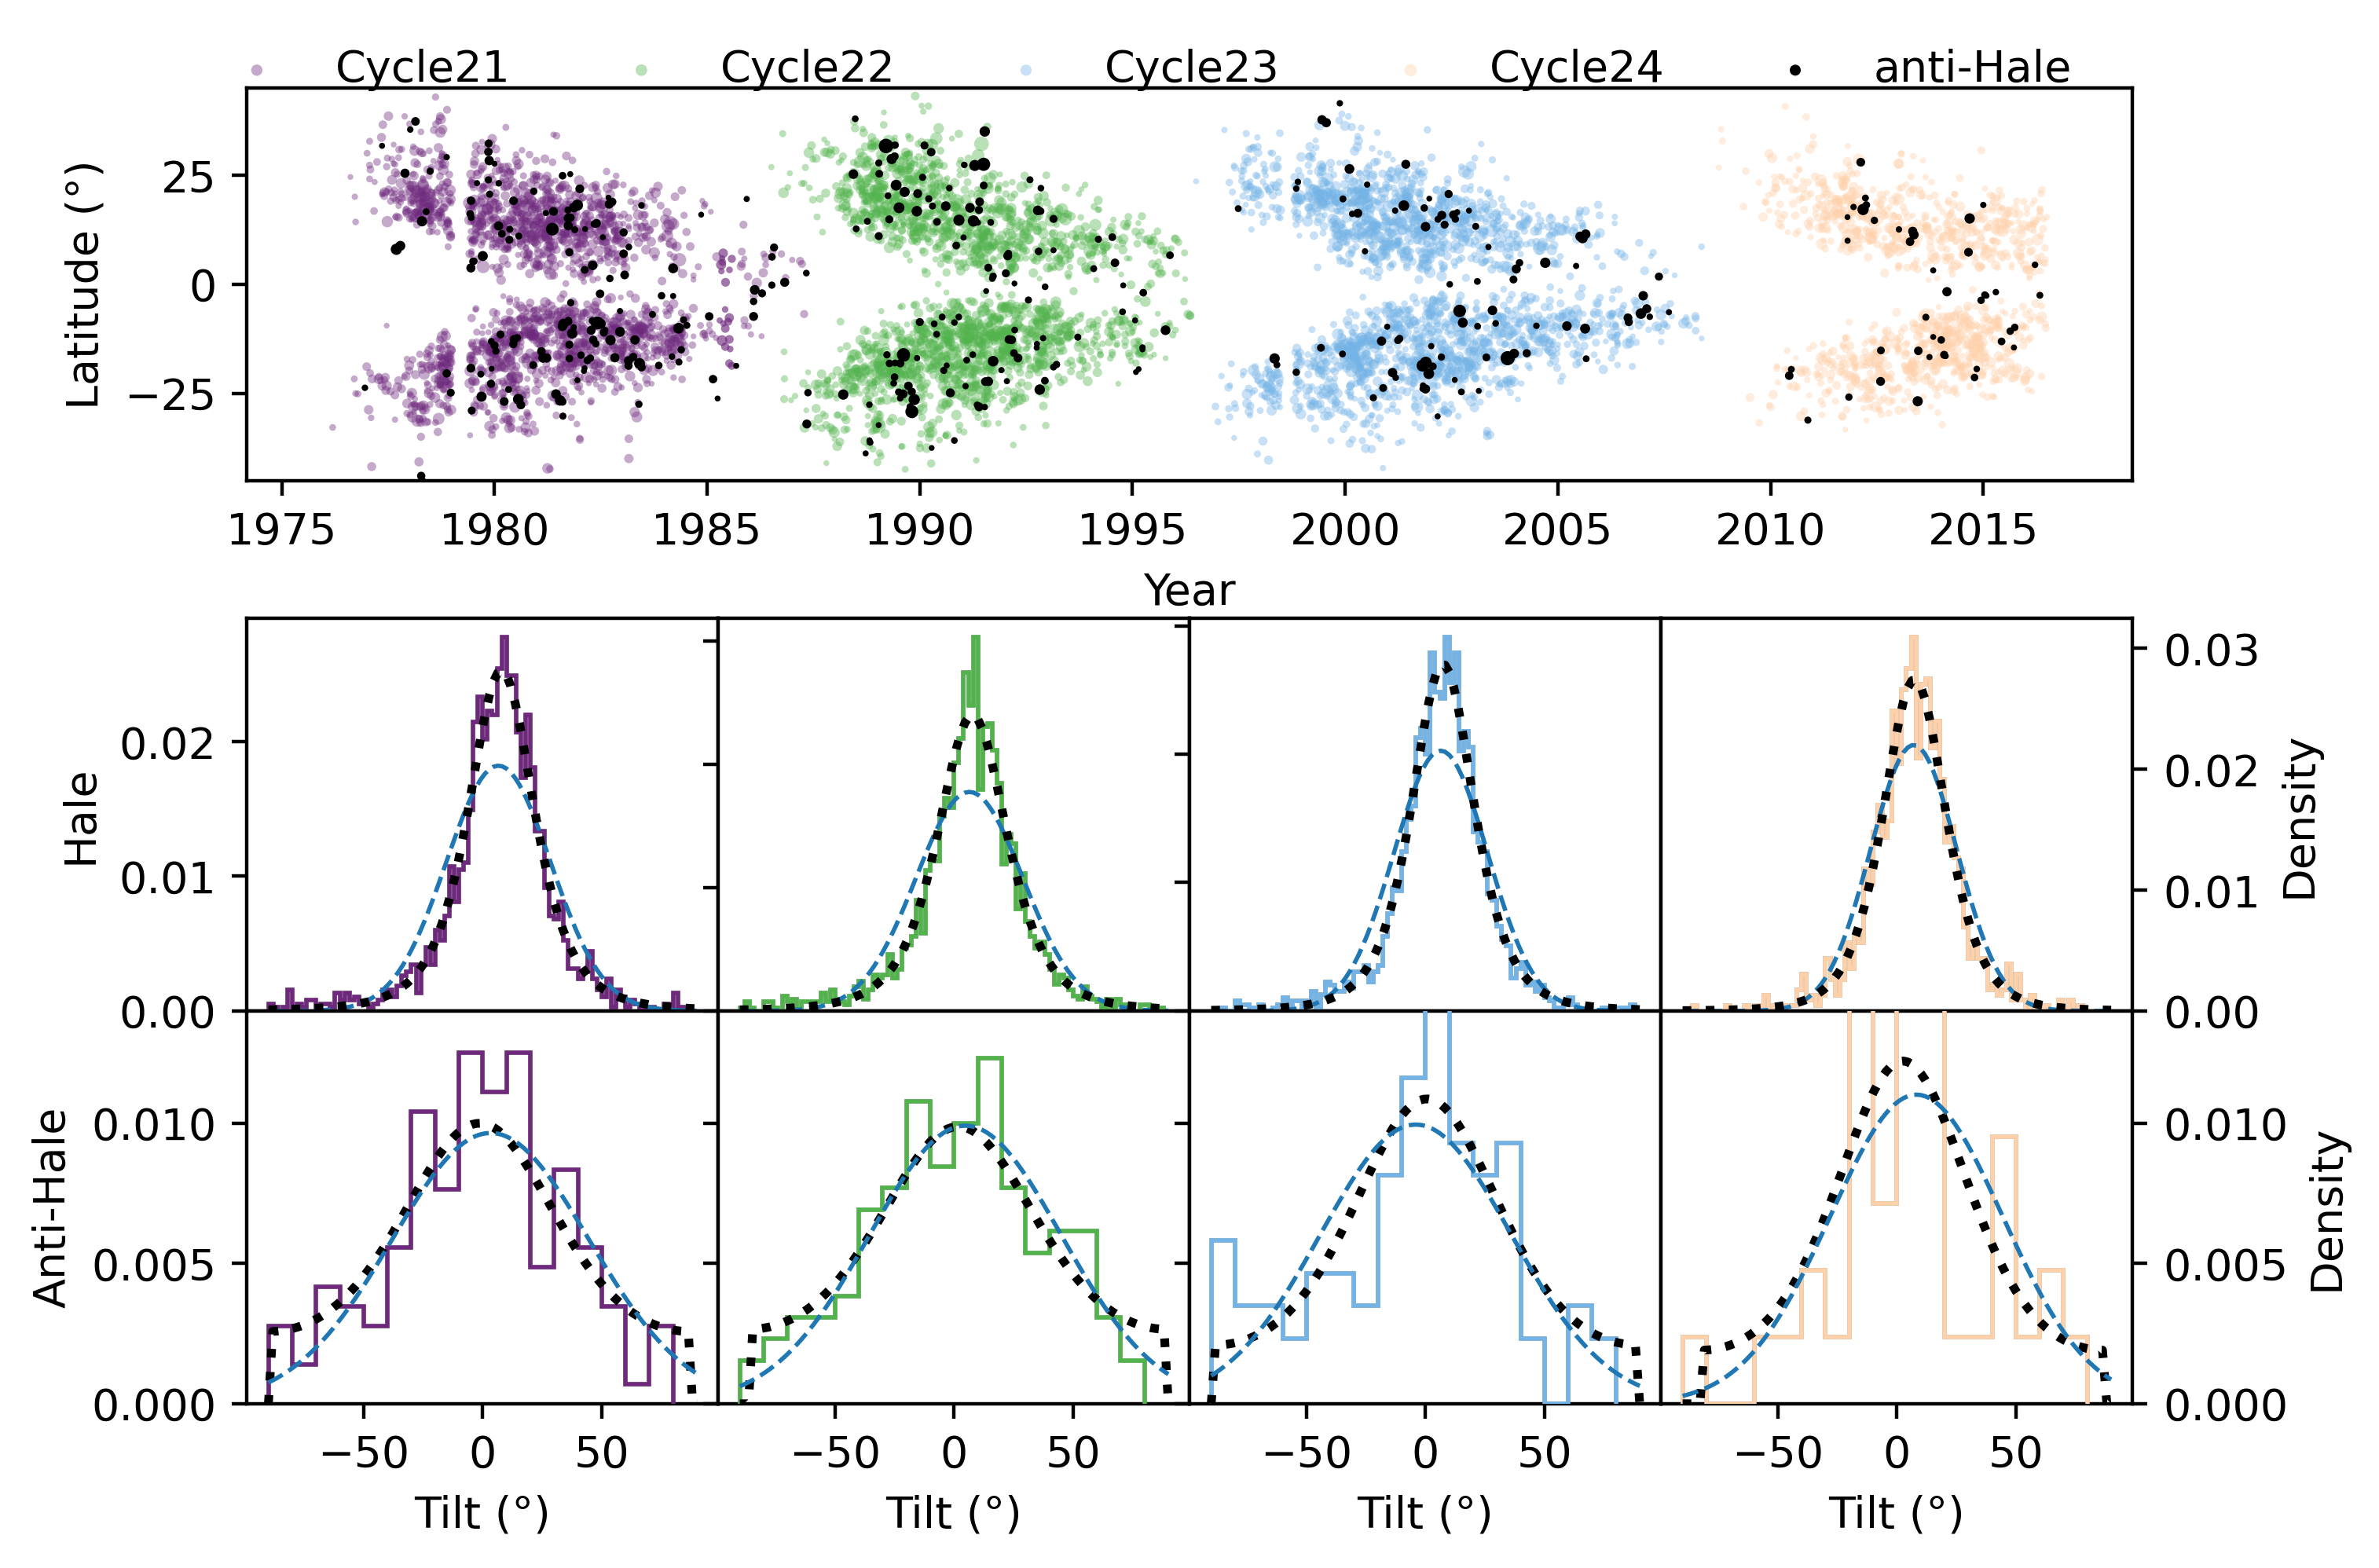

In [13]:
tbins = np.arange(-90, 90, 2)
x = np.linspace(-90, 90, 100)

# Size definitions
dpi = 400
pxx = 600  # Horizontal size of each panel
pxy = 500  # Vertical size of each panel

nph = 5     # Number of horizontal panels
npv = 6     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


# Combine hemispheres 


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

ax1 = fig.add_axes([ppadh, ppadv, 4*ppxx, ppxy])

size = (np.sqrt(allMag['BMRFlux']/1e21))
for cyc in np.arange(21,25):

    mask = np.logical_or(allMag[f'Cycle{str(cyc)}n'],allMag[f'Cycle{str(cyc)}s'])
    ax1.scatter(allMag.loc[mask,'Date'], allMag.loc[mask,'BMRLatitude'], s=size[mask], alpha=0.4, ec='None', label=f'Cycle{str(cyc)}', c=Clr[cyc-19])

    tbins = np.arange(-90, 90, 2)
    ax2 = fig.add_axes([ppadh + (cyc-21)*ppxx, ppadv-ppxy*1.35, ppxx, ppxy])
    mask = np.logical_and(mask, allMag[f'Hale'])
    tilt = np.concatenate((-allMag.loc[np.logical_and(mask, allMag['BMRLatitude']>0),'Tilt_rel'], allMag.loc[np.logical_and(mask, allMag['BMRLatitude']<0),'Tilt_rel']))
    ax2.hist(tilt, bins = tbins, density=True, histtype='step', lw=1, label='Hale', color=Clr[cyc-19], zorder=3)

    ax2.plot(x, st.norm.pdf(x, *norm.fit(tilt)), color='C0', ls='--', lw=1, label='normal', zorder=3)
    ax2.plot(x, st.t.pdf(x, *t.fit(tilt)), color='k', ls=':', lw=2, label='Student\'s-t', zorder=3)    


    for cyc2 in np.arange(21,25):

        if cyc2 != cyc:

            mask2 = np.logical_or(allMag[f'Cycle{str(cyc2)}n'],allMag[f'Cycle{str(cyc2)}s'])
            mask2 = np.logical_and(mask, allMag[f'Hale'])
            tilt = np.concatenate((-allMag.loc[np.logical_and(mask2, allMag['BMRLatitude']>0),'Tilt_rel'], allMag.loc[np.logical_and(mask2, allMag['BMRLatitude']<0),'Tilt_rel']))
            ax2.hist(tilt, bins = tbins, density=True, histtype='step', lw=1, label='Hale', color=Clr[cyc2-19], alpha=0.4, zorder=1)


    ax2.set_xlabel('Tilt (°)')

    if cyc>21 and cyc<24:
        ax2.set_yticklabels([])

    if cyc==24:
        ax2.yaxis.set_label_position('right')
        ax2.yaxis.tick_right()
        ax2.set_ylabel('Density')

    if cyc==21:
        ax2.set_ylabel('Hale')



    mask = np.logical_or(allMag[f'Cycle{str(cyc)}n'],allMag[f'Cycle{str(cyc)}s'])

    tbins = np.arange(-90, 90, 10)
    ax2 = fig.add_axes([ppadh + (cyc-21)*ppxx, ppadv-ppxy*2.35, ppxx, ppxy])
    mask = np.logical_and(mask, allMag[f'AntiHale'])
    tilt = np.concatenate((-allMag.loc[np.logical_and(mask, allMag['BMRLatitude']>0),'Tilt_rel'], allMag.loc[np.logical_and(mask, allMag['BMRLatitude']<0),'Tilt_rel']))
    ax2.hist(tilt, bins = tbins, density=True, histtype='step', lw=1, label='Hale', color=Clr[cyc-19], zorder=3)




    ax2.plot(x, st.vonmises_line.pdf(x*np.pi/180, *vonmises_line.fit(tilt*np.pi/180))*np.pi/180, color='k', ls=':', lw=2, label='normal', zorder=3)
    ax2.plot(x, st.norm.pdf(x, *norm.fit(tilt)), color='C0', ls='--', lw=1, label='normal', zorder=3)

    for cyc2 in np.arange(21,25):

        if cyc2 != cyc:

            mask2 = np.logical_or(allMag[f'Cycle{str(cyc2)}n'],allMag[f'Cycle{str(cyc2)}s'])
            mask2 = np.logical_and(mask, allMag[f'AntiHale'])
            tilt = np.concatenate((-allMag.loc[np.logical_and(mask2, allMag['BMRLatitude']>0),'Tilt_rel'], allMag.loc[np.logical_and(mask2, allMag['BMRLatitude']<0),'Tilt_rel']))
            ax2.hist(tilt, bins = tbins, density=True, histtype='step', lw=1, label='Hale', color=Clr[cyc2-19], alpha=0.4, zorder=1)


    ax2.set_xlabel('Tilt (°)')
    ax2.set_ylim([0, 0.014])

    if cyc>21 and cyc<24:
        ax2.set_yticklabels([])

    if cyc==24:
        ax2.yaxis.set_label_position('right')
        ax2.yaxis.tick_right()
        ax2.set_ylabel('Density')

    if cyc==21:
        ax2.set_ylabel('Anti-Hale')        
    


mask = allMag['AntiHale']
ax1.scatter(allMag.loc[mask,'Date'], allMag.loc[mask,'BMRLatitude'], s=size[mask], alpha=1,fc='k', ec='None', label='anti-Hale')


ax1.set_ylim([-45, 45])
ax1.set_ylabel('Latitude (°)')
ax1.set_xlabel('Year')
ax1.legend(frameon=False, ncol=5, loc='upper center', bbox_to_anchor=(0.475, 1.2))

### Akaike Information Criterion on different cycles

In [14]:


# AKAIKE
def aic(data, dist, distname):
    if distname=='vonmises_l':
        log_likelihood = dist.logpdf(data, *dist.fit(data))
    else:
        log_likelihood = dist.logpdf(data, *dist.fit(data))
    aic_score =  2 * len(dist.fit(data)) - 2 * np.sum(log_likelihood)
    return aic_score

def aic_analysis(data):
#     dist = np.array([norm, cauchy, t, lognorm, fisk, skewnorm, exponweib])
#     dist1 = ['norm', 'cauchy', 't-student', 'lognorm', 'loglogistic', 'skewnorm', 'exponweib']
    dist = np.array([t, laplace, logistic, vonmises_line, skewnorm, norm, cauchy])
    dist1 = ['t-student', 'laplace', 'logistic', 'vonmises_l', 'skewnorm', 'norm','cauchy']

    akaike = np.zeros(len(dist))
    for k in range(len(dist)):
        akaike[k] = aic(data, dist[k], dist1[k])
        
    
    KS = np.zeros(len(dist))
    p = np.zeros(len(dist))
    for k in range(len(dist)):
        if dist1[k]=='vonmises_l':
            print(dist1[k], dist[k].fit(data))
        else:
            print(dist1[k], dist[k].fit(data))
        KS[k], p[k] = st.ks_1samp(data, dist[k](*dist[k].fit(data)).cdf)

    RL = np.exp((min(akaike) - akaike)/2)
    AICw = np.round(RL/np.sum(RL),2)
    df = pd.DataFrame({'dist': dist1, 'ΔAIC': np.round(akaike - min(akaike),2), 'RelativeLikelihood': np.round(RL,2), 'AICw': AICw, 'KS': np.round(KS,3), 'p': np.round(p,2)})
    return df

def lat_aic(data, lat_data, maxim=4, interval=10):
    # Asumption that data already has been corrected to combine
    
    df = pd.DataFrame(aic_analysis(data)['dist'])
    for i in np.arange(0, maxim, 1):
        name = 'RL ' + str(i*interval) + '-' + str((i+1)*interval)
        df[name] = aic_analysis(data[np.logical_and(lat_data > i*interval,
                                                    lat_data < (i+1)*interval)])['AICw']
        
    return df

### Hale

In [15]:
for cyc in np.arange(21,25):
    mask = np.logical_or(allMag[f'Cycle{str(cyc)}n'],allMag[f'Cycle{str(cyc)}s'])
    mask = np.logical_and(mask, allMag[f'Hale'])
    tilt = np.concatenate((-allMag.loc[np.logical_and(mask, allMag['BMRLatitude']>0),'Tilt_rel'], allMag.loc[np.logical_and(mask, allMag['BMRLatitude']<0),'Tilt_rel']))
    print(f'Cycle {cyc} ------------------------------')
    df = aic_analysis(tilt)
    print(df)

Cycle 21 ------------------------------
t-student (3.2077381697748133, 7.851735836777384, 14.606395911082725)
laplace (7.96499615262943, 15.501142216106597)
logistic (7.4848153214281465, 11.296832915521867)
vonmises_l (2.874638955372045, 7.216495559054838, 30.840403557480094)
skewnorm (-1.5168009540009297, 25.693433505237692, 29.053215599289626)
norm (6.606866807844698, 21.904145690498304)
cauchy (8.1109124004522, 10.298948981933492)
         dist    ΔAIC  RelativeLikelihood  AICw     KS     p
0   t-student    0.00                1.00  0.99  0.016  0.68
1     laplace    9.51                0.01  0.01  0.025  0.19
2    logistic   63.70                0.00  0.00  0.035  0.02
3  vonmises_l   74.54                0.00  0.00  0.050  0.00
4    skewnorm  208.51                0.00  0.00  0.072  0.00
5        norm  282.56                0.00  0.00  0.084  0.00
6      cauchy  319.22                0.00  0.00  0.057  0.00
Cycle 22 ------------------------------
t-student (3.3697491907334847, 7.6

### Anti-Hale

In [16]:
for cyc in np.arange(21,25):
    mask = np.logical_or(allMag[f'Cycle{str(cyc)}n'],allMag[f'Cycle{str(cyc)}s'])
    mask = np.logical_and(mask, allMag[f'AntiHale'])
    tilt = np.concatenate((-allMag.loc[np.logical_and(mask, allMag['BMRLatitude']>0),'Tilt_rel'], allMag.loc[np.logical_and(mask, allMag['BMRLatitude']<0),'Tilt_rel']))
    print(f'Cycle {cyc} ------------------------------')
    df = aic_analysis(tilt)
    print(df)

Cycle 21 ------------------------------
t-student (418290311.2862911, 3.294394601429426, 41.33972381266514)
laplace (2.250248789610824, 32.85200236198563)
logistic (2.924476303917519, 23.71853745747896)
vonmises_l (0.6779591048350753, -1.3404805227519572, 28.043970205674512)
skewnorm (0.5802731545492101, -14.775786759656164, 45.116927161143224)
norm (3.2943961338421093, 41.340121373546324)
cauchy (1.967773623661208, 24.415518694588044)
         dist   ΔAIC  RelativeLikelihood  AICw     KS     p
0   t-student  23.07                 0.0   0.0  0.052  0.78
1     laplace  34.74                 0.0   0.0  0.061  0.59
2    logistic  25.36                 0.0   0.0  0.038  0.97
3  vonmises_l   0.00                 1.0   1.0  0.063  0.55
4    skewnorm  23.04                 0.0   0.0  0.050  0.82
5        norm  21.07                 0.0   0.0  0.052  0.78
6      cauchy  75.15                 0.0   0.0  0.089  0.16
Cycle 22 ------------------------------
t-student (1083935530.423653, 4.75334643

# Tilt averages and standard deviations

# BMRs

In [17]:
# allMag

BMR_R = (allMag['PpixelAvgRadius'] + allMag['NpixelAvgRadius'])/2

DBMr = 3/(4*np.pi)*allMag['BMRFlux']/(allMag['BMRArea']*1e4)*BMR_R*np.pi/180

DBMr_HH = DBMr[allMag.Hale]*2*np.cos(allMag[allMag.Hale].BMRLatitude*np.pi/180)*( np.sin(allMag[allMag.Hale].PLatitude*np.pi/180) - np.sin(allMag[allMag.Hale].NLatitude*np.pi/180) )

DBMr_AH = -DBMr[allMag.AntiHale]*2*np.cos(allMag[allMag.AntiHale].BMRLatitude*np.pi/180)*( np.sin(allMag[allMag.AntiHale].NLatitude*np.pi/180) - np.sin(allMag[allMag.AntiHale].PLatitude*np.pi/180) )

In [18]:
allMag['BMRColatitude'] = (90 - allMag.BMRLatitude) * np.pi/180
allMag['PColatitude'] = (90 - allMag.PLatitude) * np.pi/180
allMag['NColatitude'] = (90 - allMag.NLatitude) * np.pi/180

R_sun = 6.96 * 10e8 * 10e2  # cm

D_bmr = - (3/(4*np.pi)) * allMag.BMRFlux * np.sin(allMag.BMRColatitude) * (allMag.PColatitude - allMag.NColatitude) / R_sun**2

D_bmr_HH = D_bmr[allMag.Hale]
D_bmr_AH = D_bmr[allMag.AntiHale]

In [19]:
DBMrs = pd.concat([DBMr_HH, DBMr_AH])
DBMrs = pd.DataFrame(DBMrs)
allMag['DBMr'] = D_bmr

# Active longitudes

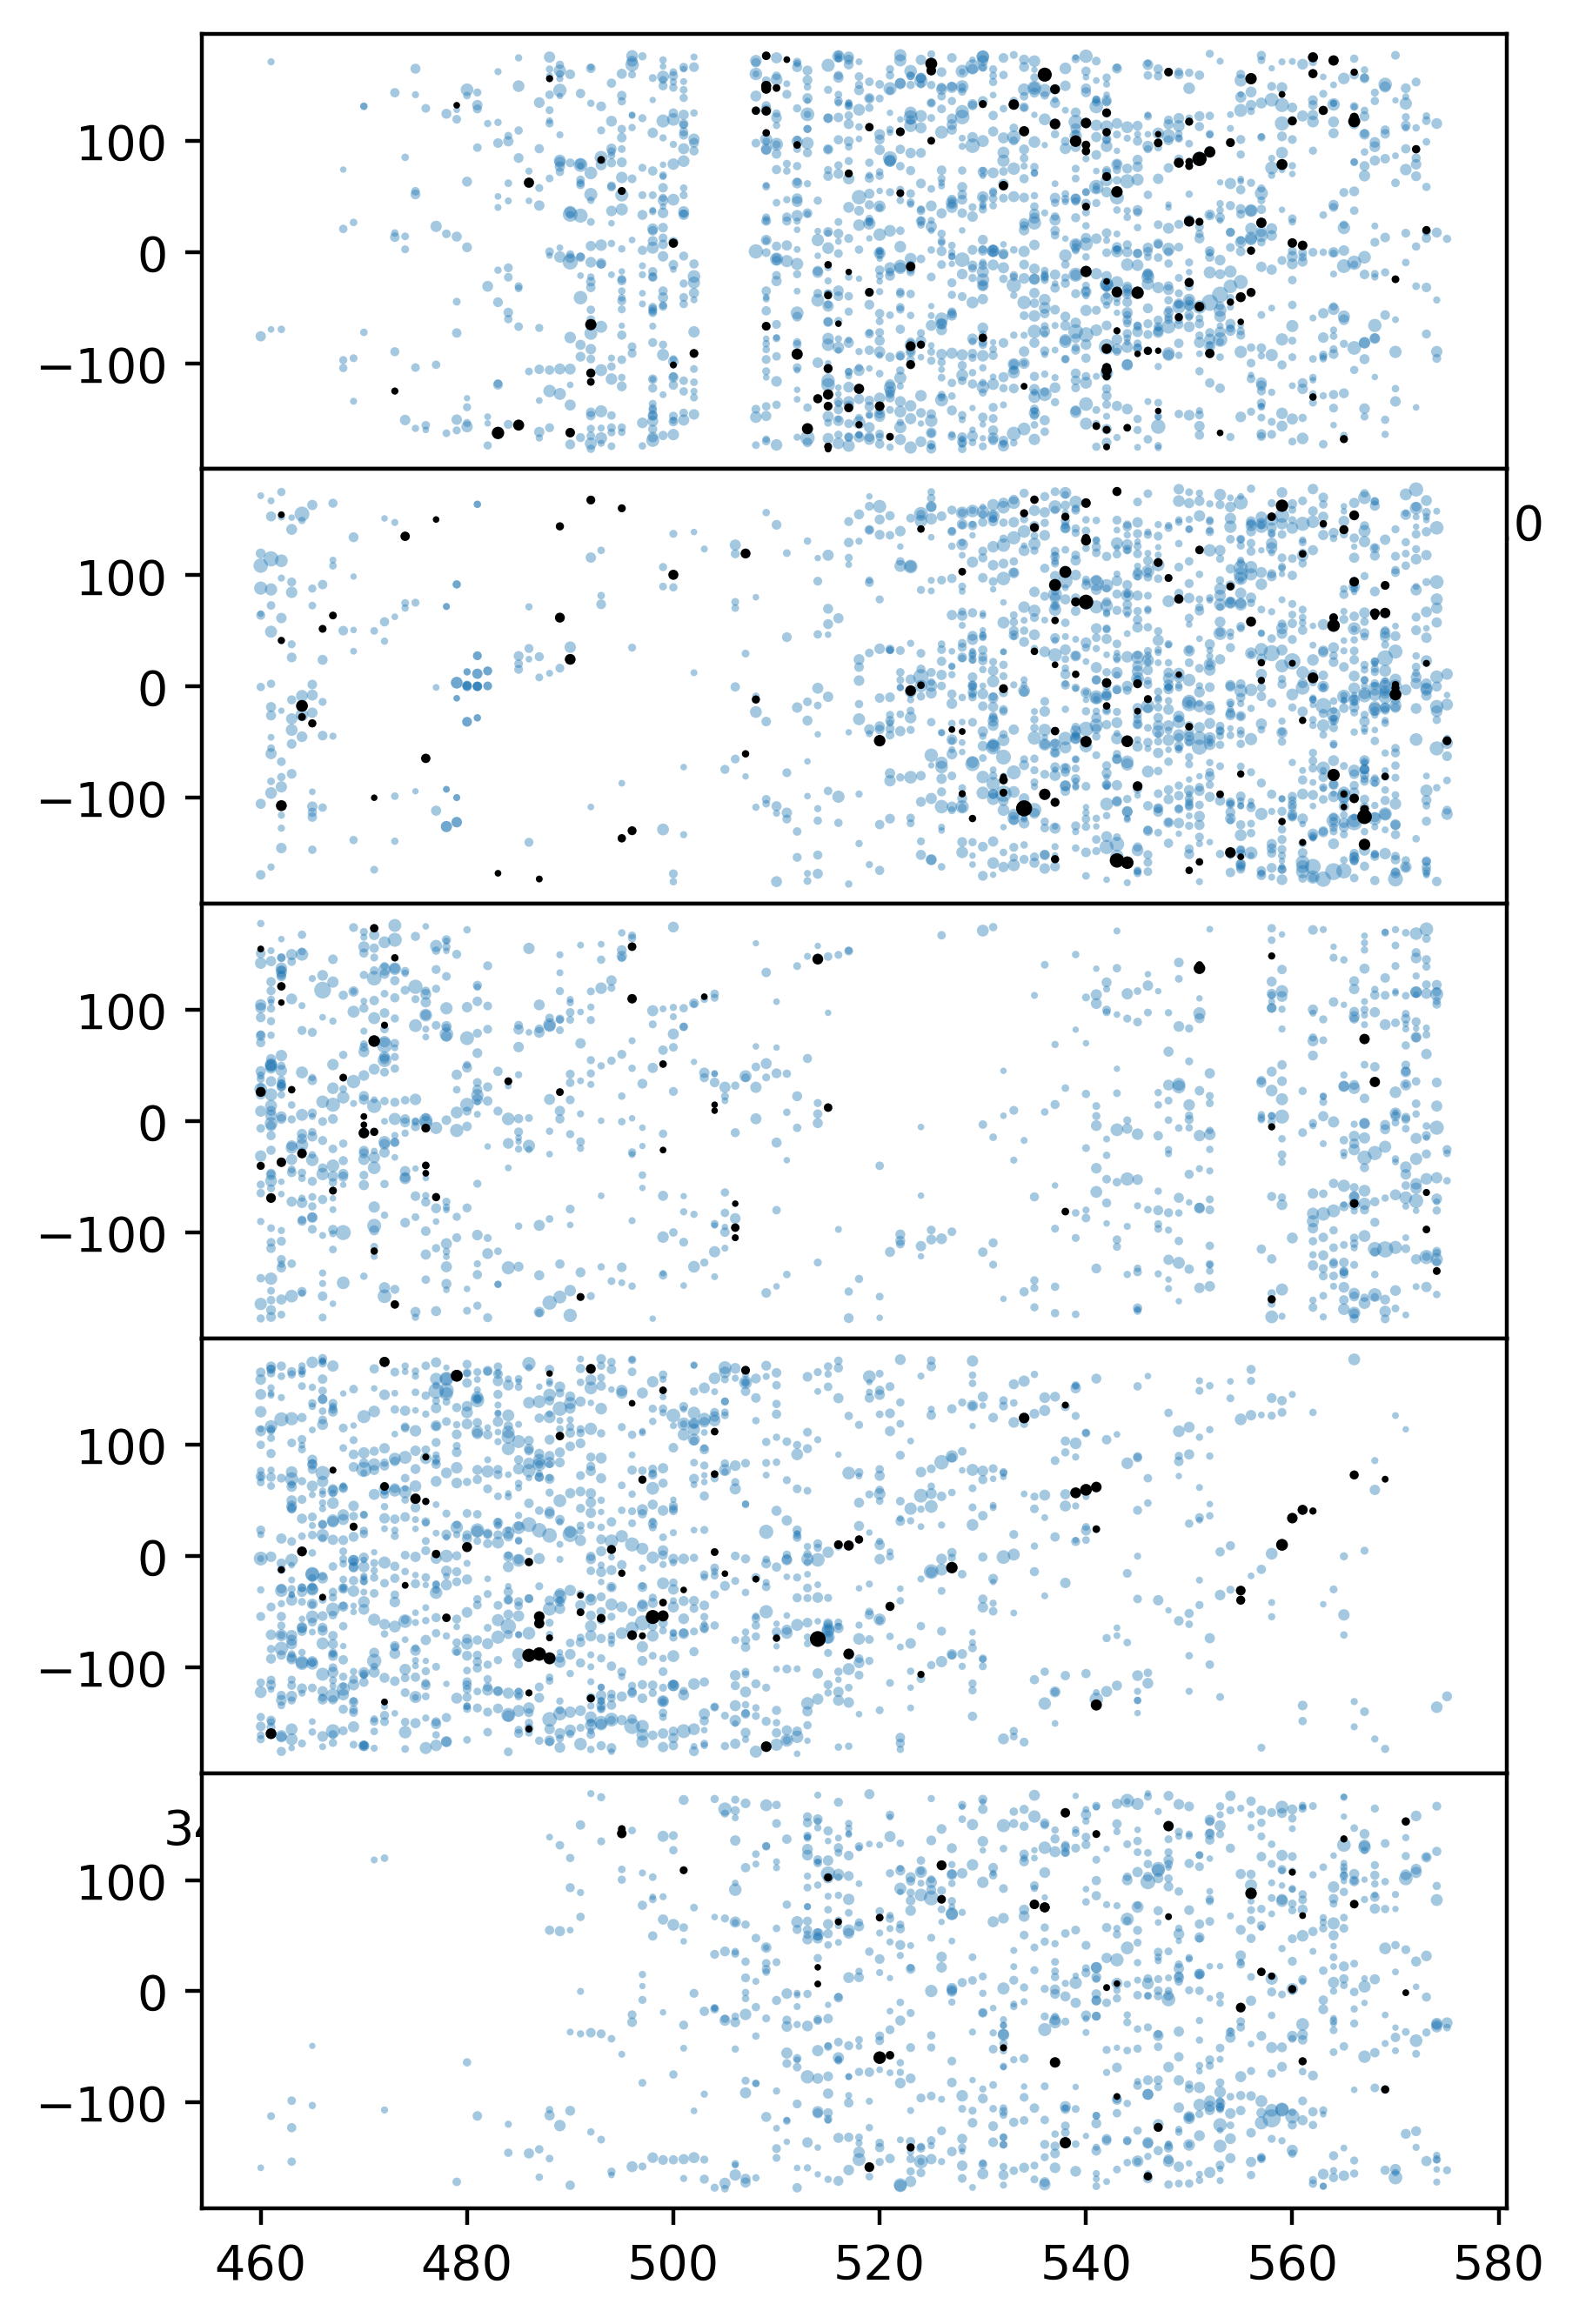

In [20]:
duration = pd.Timedelta(8*365, "d") # In years
t1 = np.min(allMag['Date'])
t2 = np.max(allMag['Date'])

rotation_rate = 25.38 # in days

allMag['Rot_time'] = np.floor((allMag['Date']-np.min(allMag['Date'])).dt.days//rotation_rate)

# allMag['BMRLongitude'] -= 360*allMag['BMRLongitude']//360

ncycles = np.round((t2-t1)/duration)


# Size definitions
dpi = 400
pxx = 1500  # Horizontal size of each panel
pxy = 500  # Vertical size of each panel

nph = 5     # Number of horizontal panels
npv = 6     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


# Combine hemispheres 


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)



size = (np.sqrt(allMag['BMRFlux']/1e21))
for n in np.arange(0,ncycles):
    
    ax1 = fig.add_axes([ppadh, ppadv-n*ppxy, ppxx, ppxy])

    # mask = np.logical_and(allMag['Date']>=t1+n*duration, allMag['Date']<t1+(n+1)*duration)
    # ax1.scatter(allMag.loc[mask,'Date'], allMag.loc[mask,'BMRLongitude'], s=size[mask], alpha=0.4, ec='None')

    # mask = np.logical_and(mask, allMag['AntiHale'])
    # ax1.scatter(allMag.loc[mask,'Date'], allMag.loc[mask,'BMRLongitude'], s=size[mask], alpha=1,fc='k', ec='None')


    mask = np.logical_and(allMag['Date']>=t1+n*duration, allMag['Date']<t1+(n+1)*duration)
    ax1.scatter(allMag.loc[mask,'Rot_time'], allMag.loc[mask,'BMRLongitude'], s=size[mask], alpha=0.4, ec='None')

    mask = np.logical_and(mask, allMag['AntiHale'])
    ax1.scatter(allMag.loc[mask,'Rot_time'], allMag.loc[mask,'BMRLongitude'], s=size[mask], alpha=1,fc='k', ec='None')    

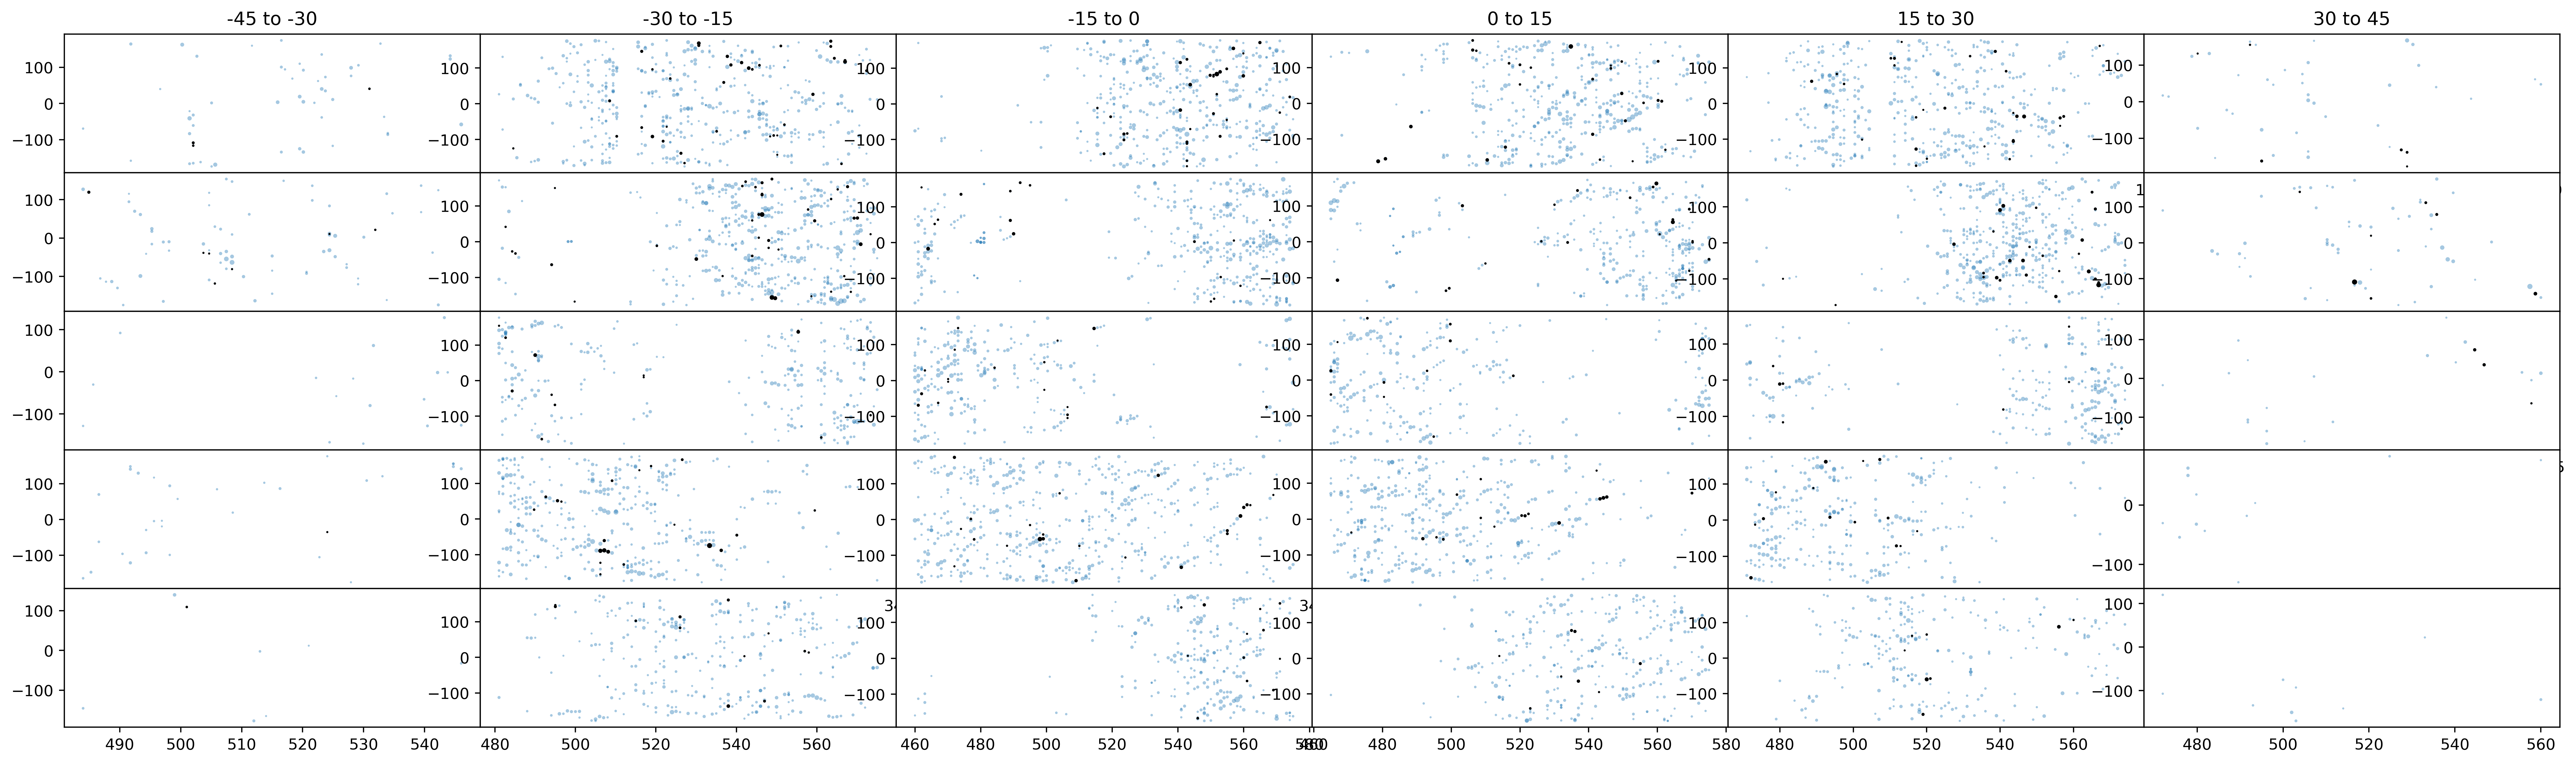

In [21]:
duration = pd.Timedelta(8*365, "d") # In years
t1 = np.min(allMag['Date'])
t2 = np.max(allMag['Date'])

rotation_rate = 25.38 # in days

allMag['Rot_time'] = np.floor((allMag['Date']-np.min(allMag['Date'])).dt.days//rotation_rate)

# allMag['BMRLongitude'] -= 360*allMag['BMRLongitude']//360

ncycles = np.round((t2-t1)/duration)


# Size definitions
dpi = 400
pxx = 1500  # Horizontal size of each panel
pxy = 500  # Vertical size of each panel

nph = 5     # Number of horizontal panels
npv = 6     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


# Combine hemispheres 


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)



size = (np.sqrt(allMag['BMRFlux']/1e21))

for i in np.arange(0,6):

    l1 = -45+i*15
    l2 = -45+(i+1)*15

    for n in np.arange(0,ncycles):
        
        ax1 = fig.add_axes([ppadh+i*ppxx, ppadv-n*ppxy, ppxx, ppxy])

        mask = np.logical_and(allMag['Date']>=t1+n*duration, allMag['Date']<t1+(n+1)*duration)
        mask = np.logical_and(mask, allMag['BMRLatitude']>=l1)
        mask = np.logical_and(mask, allMag['BMRLatitude']<l2)
        ax1.scatter(allMag.loc[mask,'Rot_time'], allMag.loc[mask,'BMRLongitude'], s=size[mask], alpha=0.4, ec='None')

        mask = np.logical_and(mask, allMag['AntiHale'])
        ax1.scatter(allMag.loc[mask,'Rot_time'], allMag.loc[mask,'BMRLongitude'], s=size[mask], alpha=1,fc='k', ec='None')

        if n==0:
            ax1.set_title(f'{l1} to {l2}')

     

In [22]:
# reference day
# time_0 = '1970-01-01 00:00:00'

time_0 = pd.to_datetime(0)
ref_day = (allMag['Date'] - time_0)

for i in range(len(ref_day)):
    ref_day[i] = ref_day[i].days

allMag['ReferenceDay'] = ref_day
ref_day

/tmp/ipykernel_16405/3177668154.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2203' has dtype incompatible with timedelta64[ns], please explicitly cast to a compatible dtype first.
  ref_day[i] = ref_day[i].days


0        2203
1        2236
2        2241
3        2263
4        2415
        ...  
7538    16964
7539    16969
7540    16970
7541    16972
7542    16981
Name: Date, Length: 7543, dtype: object

In [23]:
ref_day

0        2203
1        2236
2        2241
3        2263
4        2415
        ...  
7538    16964
7539    16969
7540    16970
7541    16972
7542    16981
Name: Date, Length: 7543, dtype: object

In [24]:
# diferential rotation

def dif_rotation(lat):
    A = 14.713              # degrees/days
    B = -2.396              # degrees/days
    C = -1.787              # degrees/days
    c_r = 360 / 25.38       # degrees/days

    return(A - c_r + B * np.sin(np.pi * lat / 180)**2 + C * np.sin(np.pi * lat / 180)**4)

## Tarea Oct/12/23

- Para una region, calcular la distancia a todas las demas usando la latitud y la longitud corregida
- Hacer la matriz de distancias
- revisar que sea simétrica
- se puede visualizar usando ax.pcolormesh

### brownie points
- probar el hdbscan con esa matriz

Ejemplo de visualización https://hdbscan.readthedocs.io/en/latest/parameter_selection.html

Usar UMAP:  https://umap-learn.readthedocs.io/en/latest/
si no, t-SNE


In [28]:
# identifier

def identifier(all_mag, region, lat_tol, lon_tol, d_before, d_after):

    d_before = pd.Timedelta(d_before, 'd')
    d_after = pd.Timedelta(d_after, 'd')

    temporal = pd.DataFrame()
    lon = region['BMRLongitude']
    lat = region['BMRLatitude']
    ref_day = region['Date']

    rotation = dif_rotation(lat)
    
    bmr_latitude = all_mag['BMRLatitude']
    bmr_longitude = all_mag['BMRLongitude']

    rotation_diff = dif_rotation(bmr_latitude) - rotation
    corrected_longitude = rotation_diff * (all_mag['Date'] - ref_day).dt.days + bmr_longitude

    corrected_longitude[corrected_longitude > 180] = corrected_longitude[corrected_longitude > 180] - 360
    corrected_longitude[corrected_longitude < -180] = corrected_longitude[corrected_longitude < -180] + 360

    # longitude correction

    all_mag['CorrectedLongitude'] = corrected_longitude

    # Calculate distance based on longitude and latidude using angles
    # https://astrophysicsformulas.com/astronomy-formulas-astrophysics-formulas/angular-distance-between-two-points-on-a-sphere/

    # # lat lim

    # lat_up = lat > 180 - lat_tol
    # lat_down = lat < lat_tol - 180

    # if lat_up:
    #     lat_range = np.logical_or(all_mag['BMRLatitude'] < lat + lat_tol - 360, lat - lat_tol < all_mag['BMRLatitude'])
    # elif lat_down:
    #     lat_range = np.logical_or(all_mag['BMRLatitude'] < lat + lat_tol, 180 - lat_tol + np.abs(-180 - lat) < all_mag['BMRLatitude'])
    # else:
    #     lat_range = np.logical_and(all_mag['BMRLatitude'] < lat + lat_tol, lat - lat_tol < all_mag['BMRLatitude'])

    # # lon lim

    # lon_up = lon > 180 - lon_tol
    # lon_down = lon < lon_tol - 180

    # if lon_up:
    #     lon_range = np.logical_or(all_mag['CorrectedLongitude'] < lon + lon_tol - 360, lon - lon_tol < all_mag['CorrectedLongitude'])
    # elif lon_down:
    #     lon_range = np.logical_or(all_mag['CorrectedLongitude'] < lon + lon_tol, 180 - lon_tol + np.abs(-180 - lon) < all_mag['CorrectedLongitude'])
    # else:
    #     lon_range = np.logical_and(all_mag['CorrectedLongitude'] < lon + lon_tol, lon - lon_tol < all_mag['CorrectedLongitude'])

    # latlon_range = np.logical_and(lat_range, lon_range)
    # t_range = np.logical_and(all_mag['Date'] < ref_day + d_after, ref_day - d_before < all_mag['Date'])
    # mask = np.logical_and(latlon_range, t_range)
    # #mask = np.logical_and(mask, all_mag['BMRLabel'] != region['BMRLabel'])
    # all_mag_mask = all_mag[mask]

    # temporal = pd.concat([temporal, all_mag_mask], ignore_index = True)

    # # ids
    # ids_np = region['BMRLabel'] * np.ones(len(all_mag_mask))
    # ids = pd.DataFrame(ids_np)
    # temporal['BMRid'] = ids

    # # time
    # time_np = region['ReferenceDay'] * np.ones(len(all_mag_mask))
    # times = pd.DataFrame(time_np)[0]
    # delta_time = temporal['ReferenceDay'] - times
    # temporal['delta_time'] = delta_time

    # # latitude
    # lat_np = region['BMRLatitude'] * np.ones(len(all_mag_mask))
    # latitudes = pd.DataFrame(lat_np)[0]
    # delta_lat = temporal['BMRLatitude'] - latitudes
    # temporal['delta_lat'] = delta_lat

    # # longitude
    # lon_np = region['BMRLongitude'] * np.ones(len(all_mag_mask))
    # longitudes = pd.DataFrame(lon_np)[0]
    # delta_lon = temporal['CorrectedLongitude'] - longitudes
    # delta_lon[delta_lon > 180] = 360 - delta_lon[delta_lon > 180]
    # delta_lon[delta_lon < -180] = -360 - delta_lon[delta_lon < -180]
    # temporal['delta_lon'] = delta_lon


    return(temporal)